In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.nn.utils import spectral_norm
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

In [ ]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform = transform)
loader = DataLoader(dataset, batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
real_batch = next(iter(loader)) # ( 128 img(1,32,32), 128 labels (0d tensor))

In [ ]:
vutils.make_grid(real_batch[0][:64], normalize=True).shape

torch.Size([3, 274, 274])

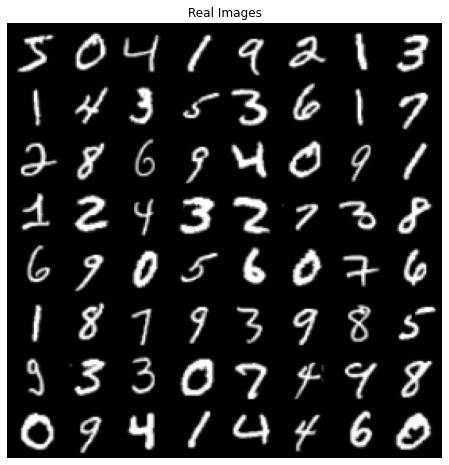

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

y.scatter(dim, where to put, who to put)

*   dim = 0 => same col diff row
*   dim = 1 => same row diff col



In [ ]:
def one_hot(y):
  y_onehot = torch.zeros(len(y), 10).to(y.device) # 10 x 10
  # y[..., None] because its zero dimensional tensor, making it 10,1

  """
  scattering 1 across 10 x 10 grid, following y index and dim = 1, same row diff col
  """

  y_onehot.scatter_(1, y[..., None], 1)
  return y_onehot[..., None, None] # adding two more dimensions at the end to make: 10 x 10 x 1 x 1

y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).long()
print(y.shape)
one_hot_y = one_hot(y)

one_hot_y.squeeze(), one_hot_y.shape

torch.Size([10])


(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 torch.Size([10, 10, 1, 1]))

In [ ]:
src = torch.arange(1, 11).reshape((2, 5))
print(src)
index = torch.tensor([[0, 1, 2, 0]])
print(index, index.shape)
print(torch.zeros(3, 5, dtype=src.dtype).scatter_(0, index, src))
print(torch.zeros(3, 5, dtype=src.dtype).scatter_(1, index, src))

print()
index = torch.tensor([[0, 1, 2], [0, 1, 4]])
print(index)
print(torch.zeros(3, 5, dtype=src.dtype).scatter_(1, index, src))

tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]])
tensor([[0, 1, 2, 0]]) torch.Size([1, 4])
tensor([[1, 0, 0, 4, 0],
        [0, 2, 0, 0, 0],
        [0, 0, 3, 0, 0]])
tensor([[4, 2, 3, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])

tensor([[0, 1, 2],
        [0, 1, 4]])
tensor([[1, 2, 3, 0, 0],
        [6, 7, 0, 0, 8],
        [0, 0, 0, 0, 0]])


Setting some extra hyperparameters to train the model

In [ ]:
noise_dim = 100
d = 32

lr_d = 0.0002
lr_g = 0.0002
beta_d = (0., 0.9)
beta_g = (0., 0.9)
epsilon_d = 1e-08
epsilon_g = 1e-08

# How many updates of the discriminator to do
# before doing one update of the generator
update_gen_every = 1

# We define lambda functions to create
# the labels for real and fake images
# given a batch size `bs`
REAL = lambda bs: torch.ones(bs)
FAKE = lambda bs: torch.zeros(bs)

In [ ]:
class SpectralConv(nn.Module):
  def __init__(self, *args, **kwargs):
    super().__init__()
    self.conv = spectral_norm(nn.Conv2d(*args, **kwargs))

  def forward(self, x):
    return self.conv(x)

In [ ]:
norm_layer = nn.InstanceNorm2d  # nn.BatchNorm2d
conv_disc_layer = SpectralConv # nn.Conv2d

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.img_branch = nn.Sequential(
        conv_disc_layer(1, 2*d, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.label_branch = nn.Sequential(
        conv_disc_layer(10, 2*d, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.classifier = nn.Sequential(
        conv_disc_layer(4*d, 8*d, 4, 2, 1),
        norm_layer(8*d),
        nn.LeakyReLU(negative_slope=0.2),
        conv_disc_layer(8*d, 16*d, 4, 2, 1),
        norm_layer(16*d),
        nn.LeakyReLU(negative_slope=0.2),
        conv_disc_layer(16*d, 1, 4, 1, 0),
        nn.Sigmoid()
    )

  def forward(self, x, y):
    #print('In D forward()')
    #print('x shape: ', x.shape)
    #print('y shape: ', y.shape)

    y = y.expand(y.shape[0], y.shape[1], x.shape[2], x.shape[3])
    #print('After expanding shape: ', y.shape)

    x = self.img_branch(x)
    y = self.label_branch(y)

    ##print('x shape: ', x.shape)
    #print('y shape: ', y.shape)

    concatenated_along_channel = torch.cat([x,y], dim=1)
    #print(concatenated_along_channel.shape)

    output = self.classifier(concatenated_along_channel)
    #print('after classifier:', output.shape)

    return output.squeeze()



In [ ]:
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/gan/disc.py
%pycat disc.py

--2023-03-03 16:09:35--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/gan/disc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1260 (1.2K) [text/plain]
Saving to: ‘disc.py.2’

disc.py.2           100%[===================>]   1.23K  --.-KB/s    in 0s      

2023-03-03 16:09:35 (55.0 MB/s) - ‘disc.py.2’ saved [1260/1260]



In [ ]:
one_hot(y).shape

torch.Size([10, 10, 1, 1])

In [ ]:
Discriminator()(torch.randn(128, 1, 32, 32), one_hot(y)).shape

torch.Size([10, 10, 1, 1])
torch.Size([10, 10, 32, 32])
x shape:  torch.Size([128, 64, 16, 16])
y shape:  torch.Size([10, 64, 16, 16])


RuntimeError: ignored

In [ ]:
# x = torch.randn(10, 1, 32, 32)
# y = torch.randn(10, 1, 32, 32)

# torch.cat((x, y), dim=1).shape

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.noise_branch = nn.Sequential(
        nn.ConvTranspose2d(noise_dim, 8*d, 4, 1, 0),
        norm_layer(8*d),
        nn.ReLU()
    )

    self.label_branch = nn.Sequential(
        nn.ConvTranspose2d(10, 8*d, 4, 1, 0),
        norm_layer(8*d),
        nn.ReLU()
    )

    self.generator_branch = nn.Sequential(
        nn.ConvTranspose2d(16*d, 8*d, 4, 2, 1),
        norm_layer(8*d),
        nn.ReLU(),
        nn.ConvTranspose2d(8*d, 4*d, 4, 2, 1),
        norm_layer(4*d),
        nn.ReLU(),
        nn.ConvTranspose2d(4*d, 1, 4, 2, 1),
        nn.Tanh()
    )

  def forward(self, z, y):
    z = self.noise_branch(z)
    y = self.label_branch(y)

    zy_concatenated_along_channel = torch.concat([z,y], dim=1)
    output = self.generator_branch(zy_concatenated_along_channel)

    return output


In [ ]:
Generator()(torch.randn(10, noise_dim, 1, 1), one_hot(y)).shape

torch.Size([10, 1, 46, 46])

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/gan/gen.py
%pycat gen.py

--2023-03-03 16:14:04--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/gan/gen.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1124 (1.1K) [text/plain]
Saving to: ‘gen.py.1’

gen.py.1            100%[===================>]   1.10K  --.-KB/s    in 0s      

2023-03-03 16:14:04 (66.2 MB/s) - ‘gen.py.1’ saved [1124/1124]



In [ ]:
def sample_z(batch_size):
  return torch.randn(batch_size, noise_dim, 1, 1).cuda()

criterion = nn.BCELoss()


In [ ]:
def train_on_batch(x_real, y_real, G, D, opt_g, opt_d, n_iter,update_gen_every=5):
  """
  x_real : real image
  y_real : actual label of images
  G      : Generator Model Object
  D      : Discriminator Model Object
  opt_g  : Generator Optimizer
  opt_d  : Discriminator Optimizer
  n_iter : Number of iterations
  update_gen_every : at which iteration would we update the generator
  """

  opt_g.zero_grad()
  opt_d.zero_grad()

  real = REAL(len(x_real)).cuda() # creating a tensor of all REAL LABEL 1
  fake = FAKE(len(x_real)).cuda() # creating a tensor of all FAKE LABEL 0

  # FIRST WE TRAIN GENERATOR
  z = sample_z(x_real.size(0))
  x_fake = G(z, y_real)
  p = D(x_fake, y_real)
  # print('disc:', p.shape)
  # print('x real shape: ', x_real.shape)
  # print('y real shape: ', y_real.shape)
  g_loss = criterion(D(x_fake, y_real), real)

  if n_iter % update_gen_every == 0:
    # backpropagating from D all the way to G
    g_loss.backward()
    # Now G's gradient buffers are filled
    opt_g.step()
  x_fake = x_fake.detach()

  # Now we train the discriminator
  opt_d.zero_grad() # since D's gradient buffer are fulled by g_loss.backward()

  d_loss = criterion(D(x_fake, y_real), fake) + criterion(D(x_real, y_real), real)
  d_loss.backward()
  opt_d.step()

  return g_loss.detach(), d_loss.detach()


In [ ]:
fixed_noise = sample_z(20).cuda()
fixed_y = one_hot(torch.cat((
    torch.arange(10), torch.arange(10)
))).cuda()

--- Epoch 0 ---


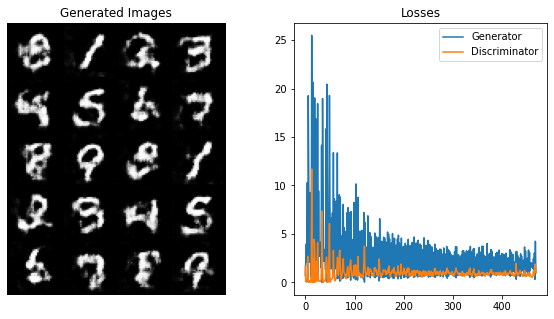

--- Epoch 1 ---


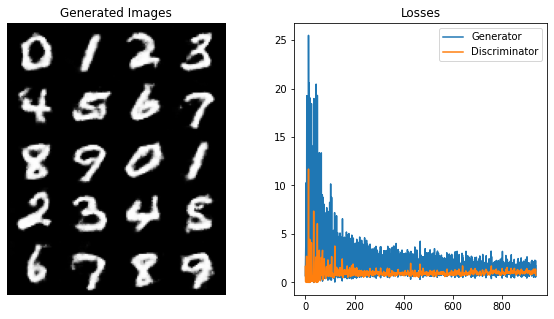

--- Epoch 2 ---


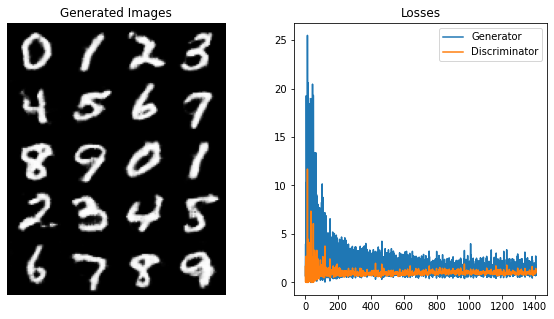

--- Epoch 3 ---


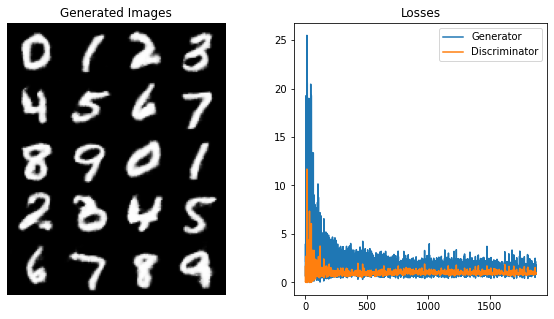

--- Epoch 4 ---


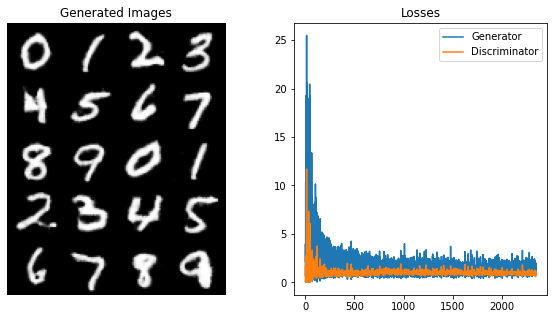

In [ ]:
epochs = 5
n_iter = 0


G = Generator().cuda()
D = Discriminator().cuda()

def normal_init(m, mean=0.0, std=0.02):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)

G.apply(normal_init)
D.apply(normal_init)

opt_g = torch.optim.Adam(G.parameters(), lr=lr_g, betas=beta_g, eps=1e-08)
opt_d = torch.optim.Adam(D.parameters(), lr=lr_d, betas=beta_d, eps=1e-08)

losses_g, losses_d = [], []
gen_imgs = []

for epoch in range(epochs):
  if epoch in (12, 16):
    opt_g.param_groups[0]['lr'] /= 10
    opt_d.param_groups[0]['lr'] /= 10

  for x, y in loader:
    x = x.cuda()
    y = one_hot(y).cuda()

    loss_g, loss_d = train_on_batch(x, y, G, D, opt_g, opt_d, n_iter, update_gen_every)
    # print(loss_g.get_device())
    losses_g.append(loss_g.detach().cpu().numpy())
    losses_d.append(loss_d.detach().cpu().numpy())

    n_iter += 1

  print(f"--- Epoch {epoch} ---")
  with torch.no_grad():
    x_fake = G(fixed_noise, fixed_y).cpu()

  gen_imgs.append(vutils.make_grid(x_fake, normalize=True, nrow=4).permute(1, 2, 0))

  f, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(gen_imgs[-1])
  axes[0].axis('off')
  axes[0].set_title("Generated Images")

  indexes = np.arange(len(losses_g))
  axes[1].plot(indexes, losses_g, label="Generator")
  axes[1].plot(indexes, losses_d, label="Discriminator")
  axes[1].set_title("Losses")
  axes[1].legend(loc="best")

  f.show()
  plt.pause(0.5)
